In [ ]:
import collections
import os
import sys
import ctypes
from pathlib import Path

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns


def _prepare_cuda_runtime():
    py_minor = f"python{sys.version_info.major}.{sys.version_info.minor}"
    cuda_root = Path(sys.prefix) / "lib" / py_minor / "site-packages" / "nvidia"
    subdirs = [
        "cublas/lib",
        "cuda_cupti/lib",
        "cuda_nvrtc/lib",
        "cuda_runtime/lib",
        "cudnn/lib",
        "cufft/lib",
        "curand/lib",
        "cusolver/lib",
        "cusparse/lib",
        "nccl/lib",
        "nvjitlink/lib",
    ]
    candidate_dirs = []
    if cuda_root.exists():
        candidate_dirs.extend(str((cuda_root / sub).resolve()) for sub in subdirs)
    candidate_dirs.extend([
        "/usr/local/cuda/lib64",
        "/usr/local/cuda/lib64/stubs",
        "/usr/lib/x86_64-linux-gnu",
    ])
    existing = os.environ.get("LD_LIBRARY_PATH", "")
    candidate_dirs.extend(path for path in existing.split(":") if path)

    deduped = []
    for path in candidate_dirs:
        if path and os.path.isdir(path) and path not in deduped:
            deduped.append(path)
    if deduped:
        os.environ["LD_LIBRARY_PATH"] = ":".join(deduped)
    os.environ.setdefault("CUDA_VISIBLE_DEVICES", "0")
    os.environ["PATH"] = "/usr/local/cuda/bin:" + os.environ.get("PATH", "")

    essential_libs = [
        "libcublas.so.12",
        "libcublasLt.so.12",
        "libcudnn.so.8",
        "libcufft.so.11",
        "libcurand.so.10",
        "libcusolver.so.11",
        "libcusparse.so.12",
        "libnccl.so.2",
        "libcuda.so.1",
        "libcudart.so.12",
        "libcudart.so.11.0",
        "libnvrtc.so.12",
        "libcupti.so.12",
    ]
    warmed = 0
    for lib_name in essential_libs:
        loaded = False
        for lib_dir in deduped:
            candidate = Path(lib_dir) / lib_name
            if candidate.exists():
                try:
                    ctypes.CDLL(str(candidate))
                    warmed += 1
                    loaded = True
                    break
                except OSError:
                    continue
        if not loaded:
            try:
                ctypes.CDLL(lib_name)
                warmed += 1
            except OSError:
                pass
    print(f"CUDA 运行库预热完毕：共尝试加载 {len(essential_libs)} 个库，成功 {warmed} 个。")


_prepare_cuda_runtime()

import tensorflow_datasets as tfds
import tensorflow.compat.v1 as tf
tf.disable_v2_behavior()  

CUDA 运行库预热完毕：共尝试加载 13 个库，成功 13 个。


2025-12-04 21:05:44.874999: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-12-04 21:05:44.924575: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-12-04 21:05:44.924606: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-12-04 21:05:44.926489: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-12-04 21:05:44.936583: I tensorflow/core/platform/cpu_feature_guar

Instructions for updating:
non-resource variables are not supported in the long term


In [ ]:
def sample_trial(pi, batch_size, class1, class2):
  images = np.zeros((batch_size, ) + class1[0].shape)
  rewards = np.zeros(batch_size)
  
  for b in range(batch_size):
    if np.random.random() < 0.5:
      images[b] = class2[np.random.randint(len(class2))]
      rewards[b] = 1.
    else:
      images[b] = class1[np.random.randint(len(class1))]
      rewards[b] = 5. if np.random.random() < pi else -3.

  return images, rewards

def running_mean(x, N):
  cumsum = np.pad(np.cumsum(x), [1, 0], 'constant')
  return (cumsum[N:] - cumsum[:-N]) / float(N)

In [ ]:
_Outputs = collections.namedtuple('Outputs', ['activations', 'values'])

class Cifar10ValueNet(object):

  _instance_idx = 0

  def __init__(self,
               num_atoms,
               initializers=None,
               regularizers=None,
               partitioners=None,
               custom_getter=None,
               name="cifar10_convnet"):
    self._num_atoms = num_atoms
    self._output_channels = [64, 64, 128, 128, 128, 256, 256, 256, 512, 512, 512]
    self._kernel_shapes = [[3, 3]] * len(self._output_channels)
    self._strides = [1, 1, 2, 1, 1, 2, 1, 1, 2, 1, 1]
    self._name = name
    Cifar10ValueNet._instance_idx += 1
    self._scope = f"{self._name}_{Cifar10ValueNet._instance_idx}"

  def __call__(self, inputs):
    net = inputs
    with tf.variable_scope(self._scope, reuse=tf.AUTO_REUSE):
      for i, (channels, kernel, stride) in enumerate(zip(
          self._output_channels, self._kernel_shapes, self._strides)):
        net = tf.layers.conv2d(
            net,
            filters=channels,
            kernel_size=kernel,
            strides=stride,
            padding='same',
            activation=tf.nn.relu,
            name=f"conv_{i}")
      flat_output = tf.reduce_mean(net, axis=[1, 2], keepdims=False, name="avg_pool")
      values = tf.layers.dense(flat_output, self._num_atoms, name="value_head")
    return _Outputs(activations=flat_output, values=values)

In [4]:
class1_ind = 3 # cat
class2_ind = 1 # car

In [5]:
# Load training images for the targeted image classes
train_ds = tfds.load("cifar10", split=tfds.Split.TRAIN)
train_class1, train_class2 = [], []

for example in tfds.as_numpy(train_ds):
  numpy_image, numpy_label = example["image"], example["label"]
  if numpy_label == class1_ind:
    train_class1.append(numpy_image)
  elif numpy_label == class2_ind:
    train_class2.append(numpy_image)

# Load testing images for the targeted image classes
test_ds = tfds.load("cifar10", split=tfds.Split.TEST)
test_class1, test_class2 = [], []

for example in tfds.as_numpy(test_ds):
  numpy_image, numpy_label = example["image"], example["label"]
  if numpy_label == class1_ind:
    test_class1.append(numpy_image)
  elif numpy_label == class2_ind:
    test_class2.append(numpy_image)

train_class1 = np.array(train_class1)
train_class2 = np.array(train_class2)

test_class1 = np.array(test_class1)
test_class2 = np.array(test_class2)

2025-12-04 21:05:46.868658: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1929] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 22188 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 4090 D, pci bus id: 0000:a9:00.0, compute capability: 8.9
2025-12-04 21:05:46.932367: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:388] MLIR V1 optimization pass is not enabled


In [6]:
print("Train:", train_class1.shape, train_class2.shape)
print("Test:", test_class1.shape, test_class2.shape)

Train: (5000, 32, 32, 3) (5000, 32, 32, 3)
Test: (1000, 32, 32, 3) (1000, 32, 32, 3)


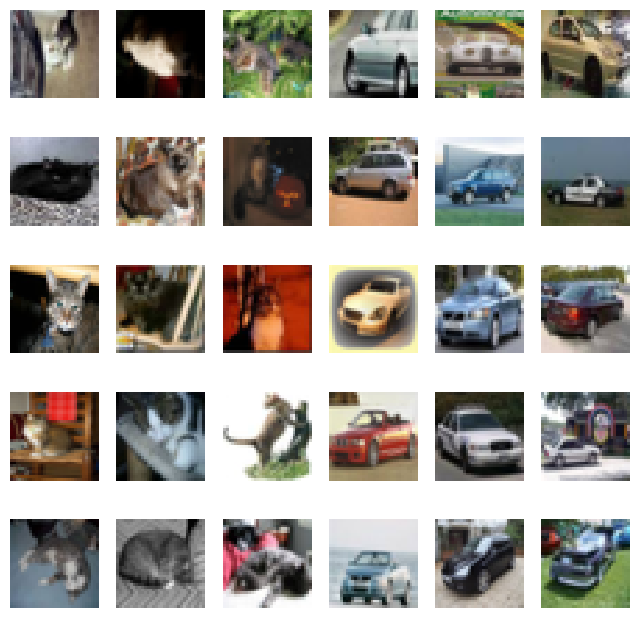

In [ ]:
fig = plt.figure(figsize=(8,8))
cnt = 1

for i in range(4):
  for j in range(6):
    plt.subplot(5, 6, cnt)
    cnt += 1
    if j <= 2:
      plt.imshow(train_class1[np.random.randint(len(train_class1))], interpolation='none')
    else:
      plt.imshow(train_class2[np.random.randint(len(train_class2))], interpolation='none')
    plt.gca().axis('off')

for j in range(6):
  plt.subplot(5, 6, cnt)
  cnt += 1
  if j <= 2:
    plt.imshow(test_class1[np.random.randint(len(test_class1))], interpolation='none')
  else:
    plt.imshow(test_class2[np.random.randint(len(test_class2))], interpolation='none')
  plt.gca().axis('off')


In [ ]:
tf.reset_default_graph()
print('Setting up graph...')

width, height = train_class1.shape[1:-1]
batch_size = 256

pi = 0.5  
mu = 1.0 

input_ph = tf.placeholder(
    tf.float32, shape=[None, width, height, 3], name="images")
reward_ph = tf.placeholder(tf.float32, shape=[None], name="rewards")

# Classic TD
value_net = Cifar10ValueNet(1)
output = value_net(input_ph)
values = tf.reshape(output.values, [-1])
td_features = output.activations

# Classic TD loss function
delta = reward_ph - values
td_loss = tf.reduce_mean(0.5 * tf.square(delta))
mse = tf.reduce_mean(tf.square(reward_ph - values))

# Distributional TD
n_atoms = 32
dist_net = Cifar10ValueNet(n_atoms)
taus_np = np.linspace(0., 1., n_atoms+2)[1:-1]
taus = tf.constant(taus_np, dtype=tf.float32)

output = dist_net(input_ph)
dist_values = output.values
dtd_features = output.activations

# Distributional TD loss function
delta = reward_ph[:, None] - dist_values
indic = tf.cast(delta <= 0., dtype=tf.float32)
weights = tf.stop_gradient(tf.abs(taus[None] - indic))

dtd_loss = tf.reduce_mean(weights * tf.abs(delta))
mse_dtd = tf.reduce_mean(tf.square(reward_ph - tf.reduce_mean(dist_values, -1)))

optimizer = tf.train.AdamOptimizer(0.0001)
update = optimizer.minimize(td_loss + dtd_loss)


Setting up graph...


/tmp/ipykernel_14553/2783529518.py:29: UserWarning: `tf.layers.conv2d` is deprecated and will be removed in a future version. Please Use `tf.keras.layers.Conv2D` instead.
  net = tf.layers.conv2d(
/tmp/ipykernel_14553/2783529518.py:38: UserWarning: `tf.layers.dense` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dense` instead.
  values = tf.layers.dense(flat_output, self._num_atoms, name="value_head")


In [9]:
num_updates_task1 = 200
num_updates_task2 = 500
num_trials = 10

losses = np.zeros((2, num_trials, num_updates_task1,))
transfer_losses = np.zeros((2, num_trials, num_updates_task2,))

for trial in range(num_trials):
  with tf.Session() as sess:
    sess.run(tf.initialize_all_variables())

    # Train for Task 1
    for epoch in range(num_updates_task1):
      imgs, rwds = sample_trial(pi, batch_size, train_class1, train_class2)
      _, loss_np, dloss_np = sess.run(
          [update, td_loss, dtd_loss],
          feed_dict={input_ph: imgs, reward_ph: rwds})

      # Record losses for later analysis
      losses[0, trial, epoch] = loss_np
      losses[1, trial, epoch] = dloss_np

      if epoch % 50 == 0:
        print("%d: Task 1 Loss %d: %f, %f" % (trial, epoch, loss_np, dloss_np))

    # Train for Task 2 (observe we change from pi to mu)
    for epoch in range(num_updates_task2):
      imgs, rwds = sample_trial(mu, batch_size, train_class1, train_class2)
      _, loss_np, dloss_np = sess.run(
          [update, td_loss, dtd_loss],
          feed_dict={input_ph: imgs, reward_ph: rwds})

      # Record losses for later analysis
      transfer_losses[0, trial, epoch] = loss_np
      transfer_losses[1, trial, epoch] = dloss_np

      if epoch % 50 == 0:
        print("%d: Task 2 Loss %d: %f %f" % (trial, epoch, loss_np, dloss_np))

Instructions for updating:
Use `tf.global_variables_initializer` instead.


2025-12-04 21:06:08.158724: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1929] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 22188 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 4090 D, pci bus id: 0000:a9:00.0, compute capability: 8.9
Instructions for updating:
Use `tf.global_variables_initializer` instead.
2025-12-04 21:06:09.316014: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:454] Loaded cuDNN version 8904
2025-12-04 21:06:09.316014: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:454] Loaded cuDNN version 8904


0: Task 1 Loss 0: 5.354452, 1.327482
0: Task 1 Loss 50: 4.456732, 0.787078
0: Task 1 Loss 50: 4.456732, 0.787078
0: Task 1 Loss 100: 4.020762, 0.699441
0: Task 1 Loss 100: 4.020762, 0.699441
0: Task 1 Loss 150: 3.728612, 0.580284
0: Task 1 Loss 150: 3.728612, 0.580284
0: Task 2 Loss 0: 4.003330 0.688748
0: Task 2 Loss 0: 4.003330 0.688748
0: Task 2 Loss 50: 0.725964 0.220978
0: Task 2 Loss 50: 0.725964 0.220978
0: Task 2 Loss 100: 0.700906 0.212100
0: Task 2 Loss 100: 0.700906 0.212100
0: Task 2 Loss 150: 0.486737 0.178156
0: Task 2 Loss 150: 0.486737 0.178156
0: Task 2 Loss 200: 0.355222 0.139701
0: Task 2 Loss 200: 0.355222 0.139701
0: Task 2 Loss 250: 0.348528 0.161887
0: Task 2 Loss 250: 0.348528 0.161887
0: Task 2 Loss 300: 0.214812 0.156976
0: Task 2 Loss 300: 0.214812 0.156976
0: Task 2 Loss 350: 0.301879 0.101539
0: Task 2 Loss 350: 0.301879 0.101539
0: Task 2 Loss 400: 0.203171 0.080022
0: Task 2 Loss 400: 0.203171 0.080022
0: Task 2 Loss 450: 0.074281 0.100007
0: Task 2 Loss 

2025-12-04 21:06:39.351020: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1929] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 22188 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 4090 D, pci bus id: 0000:a9:00.0, compute capability: 8.9


1: Task 1 Loss 0: 4.101367, 1.231458
1: Task 1 Loss 50: 4.715061, 0.873895
1: Task 1 Loss 50: 4.715061, 0.873895
1: Task 1 Loss 100: 3.836810, 0.680420
1: Task 1 Loss 100: 3.836810, 0.680420
1: Task 1 Loss 150: 3.956431, 0.623700
1: Task 1 Loss 150: 3.956431, 0.623700
1: Task 2 Loss 0: 4.373753 0.675490
1: Task 2 Loss 0: 4.373753 0.675490
1: Task 2 Loss 50: 1.270654 0.231048
1: Task 2 Loss 50: 1.270654 0.231048
1: Task 2 Loss 100: 0.518252 0.161624
1: Task 2 Loss 100: 0.518252 0.161624
1: Task 2 Loss 150: 0.390650 0.132930
1: Task 2 Loss 150: 0.390650 0.132930
1: Task 2 Loss 200: 0.480856 0.136671
1: Task 2 Loss 200: 0.480856 0.136671
1: Task 2 Loss 250: 0.361053 0.094947
1: Task 2 Loss 250: 0.361053 0.094947
1: Task 2 Loss 300: 0.405258 0.126707
1: Task 2 Loss 300: 0.405258 0.126707
1: Task 2 Loss 350: 0.275712 0.090687
1: Task 2 Loss 350: 0.275712 0.090687
1: Task 2 Loss 400: 0.209194 0.053741
1: Task 2 Loss 400: 0.209194 0.053741
1: Task 2 Loss 450: 0.206400 0.087369
1: Task 2 Loss 

2025-12-04 21:07:06.589459: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1929] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 22188 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 4090 D, pci bus id: 0000:a9:00.0, compute capability: 8.9


2: Task 1 Loss 0: 4.113737, 1.157254
2: Task 1 Loss 50: 3.844177, 0.755287
2: Task 1 Loss 50: 3.844177, 0.755287
2: Task 1 Loss 100: 3.912361, 0.670930
2: Task 1 Loss 100: 3.912361, 0.670930
2: Task 1 Loss 150: 4.390387, 0.701515
2: Task 1 Loss 150: 4.390387, 0.701515
2: Task 2 Loss 0: 4.278533 0.612815
2: Task 2 Loss 0: 4.278533 0.612815
2: Task 2 Loss 50: 1.087490 0.198504
2: Task 2 Loss 50: 1.087490 0.198504
2: Task 2 Loss 100: 0.851620 0.200991
2: Task 2 Loss 100: 0.851620 0.200991
2: Task 2 Loss 150: 0.496742 0.166656
2: Task 2 Loss 150: 0.496742 0.166656
2: Task 2 Loss 200: 0.431652 0.127414
2: Task 2 Loss 200: 0.431652 0.127414
2: Task 2 Loss 250: 0.449365 0.116753
2: Task 2 Loss 250: 0.449365 0.116753
2: Task 2 Loss 300: 0.217861 0.121612
2: Task 2 Loss 300: 0.217861 0.121612
2: Task 2 Loss 350: 0.292734 0.090894
2: Task 2 Loss 350: 0.292734 0.090894
2: Task 2 Loss 400: 0.302211 0.134853
2: Task 2 Loss 400: 0.302211 0.134853
2: Task 2 Loss 450: 0.220613 0.062075
2: Task 2 Loss 

2025-12-04 21:07:34.124677: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1929] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 22188 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 4090 D, pci bus id: 0000:a9:00.0, compute capability: 8.9


3: Task 1 Loss 0: 4.719151, 1.301781
3: Task 1 Loss 50: 3.931393, 0.756310
3: Task 1 Loss 50: 3.931393, 0.756310
3: Task 1 Loss 100: 3.914800, 0.675358
3: Task 1 Loss 100: 3.914800, 0.675358
3: Task 1 Loss 150: 3.781292, 0.613927
3: Task 1 Loss 150: 3.781292, 0.613927
3: Task 2 Loss 0: 4.282781 0.687307
3: Task 2 Loss 0: 4.282781 0.687307
3: Task 2 Loss 50: 0.854565 0.206013
3: Task 2 Loss 50: 0.854565 0.206013
3: Task 2 Loss 100: 0.630494 0.184038
3: Task 2 Loss 100: 0.630494 0.184038
3: Task 2 Loss 150: 0.540579 0.184372
3: Task 2 Loss 150: 0.540579 0.184372
3: Task 2 Loss 200: 0.290404 0.128888
3: Task 2 Loss 200: 0.290404 0.128888
3: Task 2 Loss 250: 0.274253 0.147304
3: Task 2 Loss 250: 0.274253 0.147304
3: Task 2 Loss 300: 0.262075 0.097535
3: Task 2 Loss 300: 0.262075 0.097535
3: Task 2 Loss 350: 0.255405 0.080710
3: Task 2 Loss 350: 0.255405 0.080710
3: Task 2 Loss 400: 0.204884 0.087040
3: Task 2 Loss 400: 0.204884 0.087040
3: Task 2 Loss 450: 0.125578 0.056106
3: Task 2 Loss 

2025-12-04 21:08:01.557200: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1929] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 22188 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 4090 D, pci bus id: 0000:a9:00.0, compute capability: 8.9


4: Task 1 Loss 0: 4.049831, 1.192055
4: Task 1 Loss 50: 4.183114, 0.749333
4: Task 1 Loss 50: 4.183114, 0.749333
4: Task 1 Loss 100: 3.829316, 0.653993
4: Task 1 Loss 100: 3.829316, 0.653993
4: Task 1 Loss 150: 4.108182, 0.634802
4: Task 1 Loss 150: 4.108182, 0.634802
4: Task 2 Loss 0: 3.997972 0.699439
4: Task 2 Loss 0: 3.997972 0.699439
4: Task 2 Loss 50: 0.813276 0.237369
4: Task 2 Loss 50: 0.813276 0.237369
4: Task 2 Loss 100: 0.602792 0.187178
4: Task 2 Loss 100: 0.602792 0.187178
4: Task 2 Loss 150: 0.548342 0.210803
4: Task 2 Loss 150: 0.548342 0.210803
4: Task 2 Loss 200: 0.357822 0.147459
4: Task 2 Loss 200: 0.357822 0.147459
4: Task 2 Loss 250: 0.257679 0.133723
4: Task 2 Loss 250: 0.257679 0.133723
4: Task 2 Loss 300: 0.272010 0.132224
4: Task 2 Loss 300: 0.272010 0.132224
4: Task 2 Loss 350: 0.179802 0.090152
4: Task 2 Loss 350: 0.179802 0.090152
4: Task 2 Loss 400: 0.132524 0.063081
4: Task 2 Loss 400: 0.132524 0.063081
4: Task 2 Loss 450: 0.133216 0.062463
4: Task 2 Loss 

2025-12-04 21:08:29.342504: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1929] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 22188 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 4090 D, pci bus id: 0000:a9:00.0, compute capability: 8.9


5: Task 1 Loss 0: 4.833941, 1.288162
5: Task 1 Loss 50: 3.622995, 0.661346
5: Task 1 Loss 50: 3.622995, 0.661346
5: Task 1 Loss 100: 3.886475, 0.644020
5: Task 1 Loss 100: 3.886475, 0.644020
5: Task 1 Loss 150: 4.499108, 0.685263
5: Task 1 Loss 150: 4.499108, 0.685263
5: Task 2 Loss 0: 3.812485 0.631706
5: Task 2 Loss 0: 3.812485 0.631706
5: Task 2 Loss 50: 1.137341 0.240860
5: Task 2 Loss 50: 1.137341 0.240860
5: Task 2 Loss 100: 0.599324 0.191052
5: Task 2 Loss 100: 0.599324 0.191052
5: Task 2 Loss 150: 0.421573 0.163207
5: Task 2 Loss 150: 0.421573 0.163207
5: Task 2 Loss 200: 0.357187 0.178516
5: Task 2 Loss 200: 0.357187 0.178516
5: Task 2 Loss 250: 0.301482 0.131861
5: Task 2 Loss 250: 0.301482 0.131861
5: Task 2 Loss 300: 0.263714 0.144616
5: Task 2 Loss 300: 0.263714 0.144616
5: Task 2 Loss 350: 0.228150 0.090217
5: Task 2 Loss 350: 0.228150 0.090217
5: Task 2 Loss 400: 0.257863 0.053965
5: Task 2 Loss 400: 0.257863 0.053965
5: Task 2 Loss 450: 0.130745 0.041119
5: Task 2 Loss 

2025-12-04 21:08:57.153446: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1929] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 22188 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 4090 D, pci bus id: 0000:a9:00.0, compute capability: 8.9


6: Task 1 Loss 0: 4.314816, 1.243021
6: Task 1 Loss 50: 3.951685, 0.749829
6: Task 1 Loss 50: 3.951685, 0.749829
6: Task 1 Loss 100: 4.453410, 0.715424
6: Task 1 Loss 100: 4.453410, 0.715424
6: Task 1 Loss 150: 3.754731, 0.597788
6: Task 1 Loss 150: 3.754731, 0.597788
6: Task 2 Loss 0: 3.327160 0.655607
6: Task 2 Loss 0: 3.327160 0.655607
6: Task 2 Loss 50: 0.888053 0.250383
6: Task 2 Loss 50: 0.888053 0.250383
6: Task 2 Loss 100: 0.769403 0.181849
6: Task 2 Loss 100: 0.769403 0.181849
6: Task 2 Loss 150: 0.603806 0.211695
6: Task 2 Loss 150: 0.603806 0.211695
6: Task 2 Loss 200: 0.395167 0.147805
6: Task 2 Loss 200: 0.395167 0.147805
6: Task 2 Loss 250: 0.330684 0.145825
6: Task 2 Loss 250: 0.330684 0.145825
6: Task 2 Loss 300: 0.263901 0.119653
6: Task 2 Loss 300: 0.263901 0.119653
6: Task 2 Loss 350: 0.218804 0.115834
6: Task 2 Loss 350: 0.218804 0.115834
6: Task 2 Loss 400: 0.213372 0.094888
6: Task 2 Loss 400: 0.213372 0.094888
6: Task 2 Loss 450: 0.154407 0.067214
6: Task 2 Loss 

2025-12-04 21:09:24.892148: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1929] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 22188 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 4090 D, pci bus id: 0000:a9:00.0, compute capability: 8.9


7: Task 1 Loss 0: 4.970092, 1.329007
7: Task 1 Loss 50: 4.062529, 0.773749
7: Task 1 Loss 50: 4.062529, 0.773749
7: Task 1 Loss 100: 3.681550, 0.656993
7: Task 1 Loss 100: 3.681550, 0.656993
7: Task 1 Loss 150: 4.082213, 0.643417
7: Task 1 Loss 150: 4.082213, 0.643417
7: Task 2 Loss 0: 4.095696 0.632992
7: Task 2 Loss 0: 4.095696 0.632992
7: Task 2 Loss 50: 0.867844 0.233264
7: Task 2 Loss 50: 0.867844 0.233264
7: Task 2 Loss 100: 0.592812 0.184016
7: Task 2 Loss 100: 0.592812 0.184016
7: Task 2 Loss 150: 0.407438 0.160567
7: Task 2 Loss 150: 0.407438 0.160567
7: Task 2 Loss 200: 0.503088 0.162050
7: Task 2 Loss 200: 0.503088 0.162050
7: Task 2 Loss 250: 0.483973 0.143736
7: Task 2 Loss 250: 0.483973 0.143736
7: Task 2 Loss 300: 0.225621 0.175013
7: Task 2 Loss 300: 0.225621 0.175013
7: Task 2 Loss 350: 0.146413 0.074630
7: Task 2 Loss 350: 0.146413 0.074630
7: Task 2 Loss 400: 0.123156 0.085779
7: Task 2 Loss 400: 0.123156 0.085779
7: Task 2 Loss 450: 0.042638 0.035453
7: Task 2 Loss 

2025-12-04 21:09:52.232513: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1929] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 22188 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 4090 D, pci bus id: 0000:a9:00.0, compute capability: 8.9


8: Task 1 Loss 0: 3.762938, 1.159155
8: Task 1 Loss 50: 3.647540, 0.699581
8: Task 1 Loss 50: 3.647540, 0.699581
8: Task 1 Loss 100: 4.269041, 0.722123
8: Task 1 Loss 100: 4.269041, 0.722123
8: Task 1 Loss 150: 3.907960, 0.603691
8: Task 1 Loss 150: 3.907960, 0.603691
8: Task 2 Loss 0: 3.859602 0.673878
8: Task 2 Loss 0: 3.859602 0.673878
8: Task 2 Loss 50: 0.849061 0.207233
8: Task 2 Loss 50: 0.849061 0.207233
8: Task 2 Loss 100: 0.563347 0.206666
8: Task 2 Loss 100: 0.563347 0.206666
8: Task 2 Loss 150: 0.540355 0.190344
8: Task 2 Loss 150: 0.540355 0.190344
8: Task 2 Loss 200: 0.404423 0.154057
8: Task 2 Loss 200: 0.404423 0.154057
8: Task 2 Loss 250: 0.601715 0.145205
8: Task 2 Loss 250: 0.601715 0.145205
8: Task 2 Loss 300: 0.290345 0.128912
8: Task 2 Loss 300: 0.290345 0.128912
8: Task 2 Loss 350: 0.284552 0.090435
8: Task 2 Loss 350: 0.284552 0.090435
8: Task 2 Loss 400: 0.251712 0.055319
8: Task 2 Loss 400: 0.251712 0.055319
8: Task 2 Loss 450: 0.120795 0.038420
8: Task 2 Loss 

2025-12-04 21:10:19.679403: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1929] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 22188 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 4090 D, pci bus id: 0000:a9:00.0, compute capability: 8.9


9: Task 1 Loss 0: 5.764786, 1.326458
9: Task 1 Loss 50: 4.131616, 0.771142
9: Task 1 Loss 50: 4.131616, 0.771142
9: Task 1 Loss 100: 4.236990, 0.720257
9: Task 1 Loss 100: 4.236990, 0.720257
9: Task 1 Loss 150: 3.997150, 0.645613
9: Task 1 Loss 150: 3.997150, 0.645613
9: Task 2 Loss 0: 4.566136 0.726266
9: Task 2 Loss 0: 4.566136 0.726266
9: Task 2 Loss 50: 1.059642 0.211006
9: Task 2 Loss 50: 1.059642 0.211006
9: Task 2 Loss 100: 0.666424 0.172252
9: Task 2 Loss 100: 0.666424 0.172252
9: Task 2 Loss 150: 0.637875 0.163164
9: Task 2 Loss 150: 0.637875 0.163164
9: Task 2 Loss 200: 0.522556 0.171694
9: Task 2 Loss 200: 0.522556 0.171694
9: Task 2 Loss 250: 0.382838 0.126010
9: Task 2 Loss 250: 0.382838 0.126010
9: Task 2 Loss 300: 0.439215 0.124133
9: Task 2 Loss 300: 0.439215 0.124133
9: Task 2 Loss 350: 0.275234 0.109339
9: Task 2 Loss 350: 0.275234 0.109339
9: Task 2 Loss 400: 0.284739 0.076078
9: Task 2 Loss 400: 0.284739 0.076078
9: Task 2 Loss 450: 0.159719 0.062811
9: Task 2 Loss 

In [ ]:
colours = [
    '#FF6B6B', # (Distributional TD)
    '#4ECDC4', # (Classic TD)
]

图像已保存到 birddog_loss_combined.pdf


/root/Python_code/birddog_loss_combined.pdf

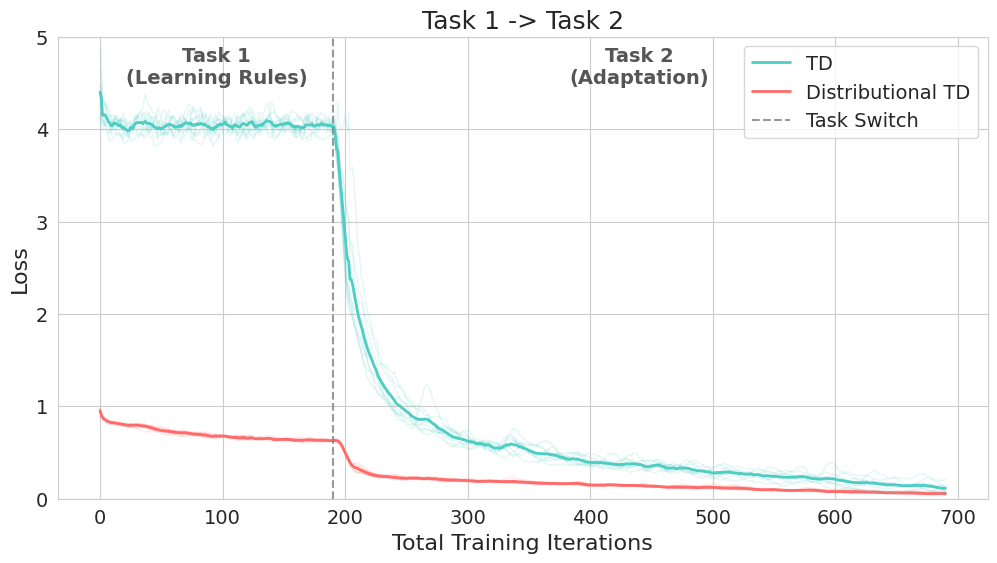

In [ ]:
sns.set_style('whitegrid')
plt.figure(figsize=(12, 6))
window = 10

all_losses = np.concatenate([losses, transfer_losses], axis=2)

# Plot Classic TD (Index 0)
plt.plot(running_mean(all_losses[0].mean(0), window), label="TD", color=colours[1], lw=2)
# Plot Distributional TD (Index 1)
plt.plot(running_mean(all_losses[1].mean(0), window), label="Distributional TD", color=colours[0], lw=2)

for trial in range(num_trials):
  plt.plot(running_mean(all_losses[0, trial], window), label=None, color=colours[1], lw=1, alpha=0.15)
  plt.plot(running_mean(all_losses[1, trial], window), label=None, color=colours[0], lw=1, alpha=0.15)

plt.axvline(x=num_updates_task1 - window, color='gray', linestyle='--', alpha=0.8, label='Task Switch')

y_max = 5.0 
plt.text((num_updates_task1 - window) / 2, y_max * 0.9, 'Task 1\n(Learning Rules)', horizontalalignment='center', fontsize=14, fontweight='bold', color='#555555')
plt.text((num_updates_task1 - window) + (num_updates_task2) / 2, y_max * 0.9, 'Task 2\n(Adaptation)', horizontalalignment='center', fontsize=14, fontweight='bold', color='#555555')

plt.title("Task 1 -> Task 2", fontsize=18)
plt.xlabel("Total Training Iterations", fontsize=16)
plt.ylabel("Loss", fontsize=16)
plt.tick_params(top=False, right=False, labelsize=14)
plt.ylim([0., y_max])
plt.legend(loc='upper right', fontsize=14)

output_path = "birddog_loss_combined.pdf"
plt.savefig(output_path)

from IPython.display import FileLink, display
print(f"图像已保存到 {output_path}")
display(FileLink(output_path, result_html_prefix="点击下载： "))